# Solution of inverse problems

## Pydata, Madrid, 8 - 10. April, 2016

A Python Gradient Descent algorithm

A simple implementation example built from scratch and application to some examples

### Tomás E. Gómez Álvarez-Arenas

####      t.gomez@csic.es,     
Institute of Information and Physical Technologies, Spanish National Research Council

#### www.us-biomat.com

Let's import some stuff...

In [97]:
import time
import numpy as np
import random
import os
import datetime
import matplotlib.pylab as plt
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

We first create a class object that corresponds to the input/output data of the GDA and some functions:

In [98]:
class Fitting(object):
    """ This defines a Fitting object, contains: 
    best fit parameters [0],
    number of steps in GD to best fit [1]
    final error[2],
    path to fit [3],
    exec time of fitting [4]
    initial guess parameters [5]
    Error_log [6]
    delta_log [7]
    
    It also contains some functions to visualize the results:
    
    plot_error_log;    plot_delta_log;   plot_path;   plot_path2;   plot_pathN;   plot_cloud  plot_Bestcloud """
    
    def __init__(self,FIT):
        self.FIT = FIT
        
    def __str__(self):
        return self.FIT

    def params(self):
        return self.FIT[0]

    def steps(self):
        return self.FIT[1]

    def error(self):
        return self.FIT[2]
        
    def path(self):
        return self.FIT[3]  
        
    def time(self):
        return self.FIT[4]
    
    def guess_0(self):
        return self.FIT[5]
        
    def error_log(self):
        return self.FIT[6]
        
    def delta_log(self):
        return self.FIT[7]
        
    def plot_error_log(self):
        plt.figure()
        plt.plot(self.error_log(),'.')
        
    def plot_delta_log(self):
        plt.figure()
        plt.plot(self.delta_log(),'.')        
            
    def plot_path(self,pars = (0,1,2),Scolor='b',goal=False,*param_goal):
        """ Returns a plot of the path followed, in the space defined by the fitting parameters, from the initial guess
        to the final solution.
        Only works for two or three fitting parameters (dimension = 2 or 3).
        If fitting is achieved in the first iteration, no plot is generated.
        If goal = True, this means that the exact solution is known, then
        parameters that correspond to the exact solution must be entered: param_goal."""
        error = self.error()
        
        if len(self.path()) > 0:

            if len(self.params()) == 2:
                a,b = pars
                print(param_goal)
                plt.figure()
                plt.plot(self.guess_0()[a],self.guess_0()[b],'og',
                         np.array(self.path())[:,a],np.array(self.path())[:,b],'.b')
                if goal: plt.plot(param_goal[a],param_goal[b],'or')
                plt.title('Path to fitting: ' + str(self.steps()) + ' steps ' + str(self.time())[0:4] + ' s'  
                          + ' Error: ' + str(error)[0:4])
                #plt.show()
                            
            if len(self.params()) >= 3:
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                a, b, c = pars
                ax.scatter(np.array(self.path())[:,a],np.array(self.path())[:,b],
                           np.array(self.path())[:,c], marker = '.', color = Scolor)
                if goal:
                    ax.scatter(param_goal[a],param_goal[b],param_goal[c], marker = 'o', color = 'g')
                ax.scatter(self.guess_0()[a],self.guess_0()[b],self.guess_0()[c], marker = 'o', color = 'r')
                plt.title('Path to fitting: ' + str(self.steps()) + ' steps ' + str(self.time())[0:4] + ' s' 
                          + ' Error: ' + str(error)[0:4])
                #plt.show()

        else: print ('No path')

    def plot_path2(self,other,pars = (0,1,2),goal=False,*param_goal):
        """ Same as plot_path, but in this case this function can plot the path to fitting of two different
        fittings (they can be the fittings of the same data set using different initial guess or using same guess
        but the stochastic approach)"""
        error = self.error()
        error2 = other.error()
        
        if len(self.path()) > 0:
            if len(self.params()) >= 3:
                a, b, c = pars
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(np.array(self.path())[:,a],np.array(self.path())[:,b],
                           np.array(self.path())[:,c], marker = '.', color = 'b')
                ax.scatter(np.array(other.path())[:,a],np.array(other.path())[:,b],
                           np.array(other.path())[:,c], marker = '.', color = 'y')
                if goal:
                    ax.scatter(param_goal[a],param_goal[b],param_goal[c], marker = 'o', color = 'r')
                ax.scatter(self.guess_0()[a],self.guess_0()[b],self.guess_0()[c], marker = 'o', color = 'g')
                plt.title('Path: ' + str(self.steps()) + ' / ' + str(other.steps()) +
                          ' steps ' + str(self.time())[0:4] + ' / ' + str(other.time())[0:4] + ' s'
                          + ' Error: ' + str(error)[0:4] + ' / ' + ' Error: ' + str(error2)[0:4])
                #plt.show()
            if len(self.params()) == 2:
                a,b = pars
                print(param_goal)
                plt.figure()
                plt.plot(self.guess_0()[a],self.guess_0()[b],'og',
                         np.array(self.path())[:,a],np.array(self.path())[:,b],'.b',
                         np.array(other.path())[:,a],np.array(other.path())[:,b],'.y')
                if goal: plt.plot(param_goal[a],param_goal[b],'or')
                plt.title('Path: ' + str(self.steps()) + ' / ' + str(other.steps()) +
                          ' steps ' + str(self.time())[0:4] + ' / ' + str(other.time())[0:4] + ' s' 
                          + ' Error: ' + str(error)[0:4] + ' / ' + ' Error: ' + str(error2)[0:4])
                #plt.show()
        else: print ('No path')
        
    def plot_pathN(self,others,pars=(0,1,2),goal=False,*param_goal):
        """ Same as plot_path2, but in this case this function can plot the path to fitting of N different
        fittings (they can be the fittings of the same data set using different initial guess or using same guess
        but the stochastic approach). The N different fittings are passed as a tuple containing the N fitting objects as
        elements of this tuple"""
        error = self.error()
        if len(self.path()) > 0:
            if len(self.params()) >= 3:
                a,b,c = pars
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(np.array(self.path())[:,a],np.array(self.path())[:,b],np.array(self.path())[:,c], 
                           marker = '.', color = 'b')
                ind = 0
                colorCh = ['c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k',
                           'b', 'g', 'r', 'c', 'm', 'y', 'k']
                markerCh = ['.', '.', '.', '.', 'x', 'x', 'x', 'x', 'x', 'x', 'x', '^', '^', '^', '^', '^', '^', '^']
                for other in others:
                    ax.scatter(np.array(other.path())[:,a],np.array(other.path())[:,b],
                                        np.array(other.path())[:,c], marker = markerCh[ind], color = colorCh[ind])
                    ind += 1
                if goal:
                    ax.scatter(param_goal[a],param_goal[b],param_goal[c], marker = 'o', color = 'r')
                ax.scatter(self.guess_0()[a],self.guess_0()[b],self.guess_0()[c], marker = 'o', color = 'g')
                plt.title('Path to fitting: ' + str(self.steps()) + ' steps ' + str(self.time())[0:4] + ' s' )
                #plt.show()
 
            if len(self.params()) == 2:
                a,b = pars
                plt.figure()
                plt.plot(self.guess_0()[a],self.guess_0()[b],'og',
                         np.array(self.path())[:,a],np.array(self.path())[:,b],'.b')
                if goal: plt.plot(param_goal[a],param_goal[b],'or')
                plt.title('Path to fitting: ' + str(self.steps()) + ' steps ' + str(self.time())[0:4] + ' s'  
                          + ' Error: ' + str(error)[0:4])
                colorCh = ['.c', '.m', '.y', '.k', 'xb', 'xg', 'xr', 'xc', 'xm', 'xy', 'xk',
                           '^b', '^g', '^r', '^c', '^m', '^y', '^k']
                n=0
                for other in others:
                     plt.plot(other.guess_0()[a],other.guess_0()[b],colorCh[n],
                              np.array(other.path())[:,a],np.array(other.path())[:,b],colorCh[n])
                     n += 1

                #plt.show()                                       
        else: print ('No path')
        
    def plot_cloud(self,others,pars=(0,1,2),goal=False,*param_goal):
        """Similar to plot_pathN, This function takes a set of N different
        fittings (they can be the fittings of the same data set using different initial guess or using same guess
        but the stochastic approach). The N different fittings are passed as a tuple containing the N fitting objects as
        elements of this tuple
        The function returns a graph with the final solution obtained by the different fittings and the actual solution
        if it is known (test problems)"""
        
        if len(self.params()) >= 3:
            a,b,c = pars
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(np.array(self.params())[a],np.array(self.params())[b],np.array(self.params())[c], 
                       marker = '.', color = 'b')
            for other in others:
                ax.scatter(np.array(other.params())[a],np.array(other.params())[b],np.array(other.params())[c], 
                           marker = '.', color = 'b')
            if goal:
                ax.scatter(param_goal[a],param_goal[b],param_goal[c], marker = 'o', color = 'r')
            other = others[-1]
            ax.scatter(np.array(other.params())[a],np.array(other.params())[b],np.array(other.params())[c], 
                       marker = 'o', color = 'g')
            #plt.show()
            
        if len(self.params()) == 2:
            a,b = pars
            plt.figure()
            plt.plot(np.array(self.params())[a],np.array(self.params())[b],'ob')
            for other in others:
                plt.plot(np.array(other.params())[a],np.array(other.params())[b],'ob')
            if goal:
                plt.plot(param_goal[a],param_goal[b],'or')
            other = others[-1]
            plt.plot(np.array(other.params())[a],np.array(other.params())[b],'og')
            #plt.show()
            
    def plot_Bestcloud(self,others,conf,pars=(0,1,2),altern='n.a.',goal=False,*param_goal):
        """Similar to plot_pathN, This function takes a set of N different
        fittings (they can be the fittings of the same data set using different initial guess or using same guess
        but the stochastic approach). The N different fittings are passed as a tuple containing the N fitting objects as
        elements of this tuple
        The function returns a graph with the final solution obtained by the different fittings and the actual solution
        if it is known (test problems)"""
        
        errorL = []
        errorL.append(self.error())
        for other in others: errorL.append(other.error())
        min_Error = np.min(errorL)
        if len(self.params()) >= 3:
            a,b,c = pars
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            if self.error() < min_Error * conf:
                ax.scatter(np.array(self.params())[a],np.array(self.params())[b],np.array(self.params())[c], 
                           marker = 'o', color = 'b')
            for other in others:
                if other.error() < min_Error * conf: 
                    ax.scatter(np.array(other.params())[a],np.array(other.params())[b],np.array(other.params())[c], 
                               marker = 'o', color = 'b')
            if goal:
                ax.scatter(param_goal[a],param_goal[b],param_goal[c], marker = 'o', color = 'r')
            other = others[-1]
            ax.scatter(np.array(other.params())[a],np.array(other.params())[b],np.array(other.params())[c], 
                       marker = 'o', color = 'g')
            if altern != 'n.a.':
                ax.scatter(altern[0],altern[1],altern[2], 
                       marker = 'o', color = 'y')
                
            #plt.show()
        if len(self.params()) == 2:
            a,b = pars
            plt.figure()
            if self.error() < min_Error * conf:
                plt.plot(np.array(self.params())[a],np.array(self.params())[b],'ob')
            for other in others:
                if other.error() < min_Error * conf: 
                    plt.plot(np.array(other.params())[a],np.array(other.params())[b],'ob')
            if goal:
                plt.plot(param_goal[a],param_goal[b],'or')
            other = others[-1]
            plt.plot(np.array(other.params())[a],np.array(other.params())[b],'og')
            #plt.show()
                 

Introduce a constrain function that can be called any time to impose constrains: relations between function parameters that must be met:

In [99]:
def Constrains(params):
    """" This function takes a set of parameters.
    Applies some constrains to the parameters and check if constrains are fulfilled.
    If yes, returns the passed parameters
    If no, returns a set of modified parameters that fulfill the constrains
    This function has to be executed any time the parameters are modified in the GD proccess"""
    pass

Define error functions called by the optimization algorithm. This error function compares the experimental data with the function output for a given set of parameters.
Normally, the error function is the L2 norm.
However, it is possible to define any kind of suitable error function.

In [100]:
def F_Error(params,x,exp_dat,target_func):
    """" This is an error function. It
    takes the parameters (tuple), the target function (function defined by the user) 
    and the independent variable vector xi, (data vector) and calculates the
    target function value for each value of xi for the given parameters, then compares 
    it with the data and returns a error:
    Assumes that the target function returns a complex number and calculates:
    Error of the magnitude (in log scale) and error of the phase
    """
    teo_dat = target_func(params,x)
    Error_M = ( np.sum( ( (np.log10(np.abs(teo_dat)) - np.log10(np.abs(exp_dat)) ) ** 2.0) ) / len(x) ) ** (1./2.)
    Error_Ph = (np.sum(((np.unwrap(np.angle(teo_dat)) - np.unwrap(np.angle(exp_dat))) ** 2.0) ) / len(x)) ** (1./2.)
    return (Error_M ** 2 + Error_Ph ** 2) ** (1./2.)
    
def F_Error2(params,x,exp_dat,target_func):
    """" This is an error function ... see before.
    In this case thie error function assumes that the target function returns a real (float) value and returns:
    the L2 norm
        """
    teo_dat = target_func(params,x)
    Error_M = (np.sum( ( np.abs(teo_dat - exp_dat) ) ** 2.0)  / len(x)) ** (1./2.)
    return Error_M

These two functions allow to change the step size and the depth of the search. As they are now step size and depth of search are kept constant.

In [101]:
def delta_func(DELT_0,dat,err):
    """This function allows to change the step size during the Gradient Descent walk"""
    delta = np.log(1.+ err / np.mean(np.abs(dat))) / 5.
    if delta > DELT_0:
        delta = DELT_0
    if delta < DELT_0 / 6.:
        delta = DELT_0 / 6.
    #return delta
    return DELT_0
    
def var_steps(steps_0,no_iter):
    """This function allows to change the number of times we try to improve the error 
    before taking a step forward in the Gradient Descent:
        step = 1: as soon as we find one point that reduces the error, we stop searching and take a
        step in that direction: Stochastic Gradient descent 
        step = 3 ** N - 1: We search the full space around the actual guess and take the step in the direction
        that minimizes the error: Gradient Descent (systematic)
    In some cases (high dimension of the space of search, it can be of interest to sart the search with
    a fully stochastic approach (step = 1) and increase step as the Gradient Descent progresses towards the solution,
    so that in the last part the algorithm correspond to the systematic Gradient Descent."""
    return steps_0

Collects all points coordinates within the discretized search volume.

In [102]:
def trinarize(decimal):
    trinary = ''
    while decimal // 3 != 0:
        trinary = str(decimal % 3) + trinary
        decimal = decimal // 3
    return str(decimal) + trinary

LayerParam is a list of tuples with the parameters of the model that will be the goal of the
optimization method (Gradient descent).

The Grad_ErrorML function, computes the local gradient of the error function only for the parameters specified in LayerParam; 

list of tuples: [(No_Layer,No_param), ...]

In [103]:
def take_params(params,selection):
    """params: list
    selection: tuple """
    params_sel = []
    if type(selection) == int: selection = (selection,selection)
    for n in range(len(params)):
        if n in selection: params_sel.append(params[n])
    return params_sel

def return_params(params_0,selection,params):
    """params and params_0: list
    selection: tuple """
    if type(selection) == int: selection = (selection,selection)
    params_mod = []
    for n in range(len(params_0)):
        if n in selection: params_mod.append(params[n])
        else: params_mod.append(params_0[n])
    return params_mod
    

This function seach around the present value of guess parameters, and sets the next step:
new guess parameters and error value at this new position

In [104]:
def Grad_ErrorML(exp_dat, guess_0, params, x, delta, NoStepsOK, Prec,target_func,Error_Func):
    """ Computes the local gradient of the error function only for the parameters specified in LayerParam; 
    exp_dat: numpy_array, vector with the value of the function at xi
    params: tuple with the position in the list of the guess_0 elements to be used for the fitting
    guess_0: list, list with the initial guess parameters
    x: numpy_array, vector with the value of the independent variable (xi)
    delta: float, step size for the GD
    NoStepsOK: int, number of steps that improve the error in the GD before setting the direction of the nest step
        NoStepsOK = 1 , the stochastic approach is used
        NoStepsOK = 3 ** len(params) - 1, the conventional GD approach is used
    Prec: float, required minimum improvement in the error (Prec <= 1)
    target_Func: function model, user defined,
    Error_Func: function, user defined, function that calculates the error exp_data and 
       calculated value of the target function for the xi values and the actual value of the function parameters"""
    
    Error0 = Error_Func(guess_0,x,exp_dat,target_func)
    grad = [1 - delta, 1.0, 1 + delta]
    param_fin = take_params(guess_0,params) #Takes only the parameters to be used in the fitting
    params_ok = []
    
    M = 3 ** len(param_fin)
    result_L=[]
    
    for n in range(M):
        """Generates a list with all points in the parameters space to be tested
        and shuffle it. This is neccesary for the stochastic case. It has no effect in the
        conventional GD case."""
        z = trinarize(n)
        base = '0'*(len(trinarize(M-1))-len(z))
        result = base + z
        result_L.append(result)
        
    random.shuffle(result_L)
    Error_count = 1
    
    for n in range(M):
        result = result_L[n]
        param_test = []
        
        for m in range(len(result)):
            param_test.append( param_fin[m] * grad[ int( result[m] )])
        
        param_test_b = return_params(guess_0,params,param_test)    
        Error = Error_Func(param_test_b,x,exp_dat,target_func)
        
        if Error < Error0 * Prec:
            params_ok = param_test_b
            Error0 = Error
            Error_count += 1
            
        if Error_count > NoStepsOK: break

    if len(params_ok) > 0: 
        return [params_ok, Error0]
    if len(params_ok) == 0:
        return [guess_0, Error0]

This function performs the Gradient Descent search by calling Grad_ErrorML at each step

In [105]:
def Walk_downGradientML(exp_dat, guess_0, params, x, delta, NoStepsOK,
                        target_func,Error_Func, MaxSteps = 500, Prec = 0.999,forwardCheck = 1):
    """ This function takes one step in the fitting procedure douwn the gradient in the error hiperspace.
    exp_dat: numpy_array, vector with the value of the function at xi
    params: tuple with the position in the list of the guess_0 elements to be used for the fitting
    guess_0: list, list with the initial guess parameters
    x: numpy_array, vector with the value of the independent variable (xi)
    delta: float, step size for the GD
    NoStepsOK: int, number of steps that improve the error in the GD before setting the direction of the nest step
        NoStepsOK = 1 , the stochastic approach is used
        NoStepsOK = 3 ** len(params) - 1, the conventional GD approach is used
    Prec: float, required minimum improvement in the error (Prec <= 1)
    target_Func: function model, user defined,
    Error_Func: function, user defined, function that calculates the error exp_data and 
       calculated value of the target function for the xi values and the actual value of the function parameters"""
    guess_00 = guess_0
    start_time = time.time()
    maxv = 0
    walk_path = []
    error_log = []
    delta_log = []
    
    params0 = params
    Error0 = Error_Func(guess_0,x,exp_dat,target_func)
    paramsF, Error = Grad_ErrorML(exp_dat, guess_0, params, x, delta, NoStepsOK, Prec,target_func,Error_Func)
    Error_break = 0
    delta0 = delta
    
    while Error < Error0 * Prec:
        delta = delta_func(delta0,exp_dat,Error)
        guess_0 = paramsF
        Error0 = Error
        NoStepsOK = var_steps(NoStepsOK,maxv)
        paramsF, Error = Grad_ErrorML(exp_dat, guess_0, params, x, delta, NoStepsOK, Prec, target_func,Error_Func)
        paramsForward = list(np.array(paramsF) + (np.array(paramsF)-np.array(guess_0)))
        ErrorForward = Error_Func(paramsForward,x,exp_dat,target_func)
        if ErrorForward  < Error * Prec:
            paramsF = paramsForward
            Error = ErrorForward
        walk_path.append(paramsF)
        error_log.append(Error)
        delta_log.append(delta)
        maxv += 1
        if maxv > MaxSteps:
            break
    Exec_time = time.time() - start_time
    
    if Error >= Error0 * Prec:
        gg = [guess_0, maxv, Error0, walk_path, Exec_time, guess_00, error_log, delta_log]

    else: 
        gg = [paramsF, maxv, Error, walk_path, Exec_time, guess_00, error_log, delta_log]
    
    if maxv > MaxSteps:
        gg = [paramsF, maxv, Error, walk_path, Exec_time, guess_00, error_log, delta_log]
    
    return Fitting(gg)

Define some example functions.

In all cases we only consider functions that depend on one variable
The variable (x) is passed as a vector
The function parameters are pased as a tuple
The function returns a vector (same length as x)

In [106]:
def lin_reg(params,x):
    """ params: [0]: slope, [1]: function value at x=0"""
    f = params[0] * x + params[1]
    return f
    
def polym_2(params,x):
    """params: [0]: cuaratic coeff; [1]: linear coeff. [2]: function value at x=0"""
    f = params[0] * (x ** 2) + params[1] * x + params[2]
    return f
    
def chirp(params,x):
    """ params: [0]: fase_0, [1]: frec0, [2]: k"""
    # k = (f1 - f0) / T
    f = np.sin(params[0] + 2 * 3.141592654 + (params[1] * x + (params[2] * x ** 2) / 2.))
    return f

def damped_chirp(params,x):
    """ params: [0]: fase_0, [1]: frec0, [2]: k"""
    # k = (f1 - f0) / T
    f = np.exp(-x*params[2]/10) * np.sin(params[0] + 2 * 3.141592654 * (params[1] * x + (params[2] * x ** 2) / 2.))
    return f    
    
def gained_chirp(params,x):
    """ params: [0]: fase_0, [1]: frec0, [2]: k"""
    f = (x ** 2 + np.max(x**2)/2.) / np.max(x**2) * np.sin(params[0] + 2 * 3.141592654 * (
            params[1] * x + (params[2] * x ** 2) / 2.))
    return f 
    
def lin_chirp(params,x):
    """ params: [0]: fase_0, [1]: frec0, [2]: k"""
    # k = (f1 - f0) / T
    f = np.sin(params[0] + 2 * 3.141592654 * (params[1] * x + (params[2] * x ** 2) / 2.))
    return f
            
def damped_osc(params,x):
    func_value = []
    j = np.complex(0,1)
    for vx in x:
        func_value.append((params[0] * np.sin(vx) + params[1] * np.cos(vx) * j) * np.exp(-params[2]*vx))
    return np.array(func_value)
    
def cT_multlay(params,freq):
    """Computes the transmission coefficient at normal incidence for a layered medium and for a given frecquency: frecu
    Takes a medium (Class object) a layered (Class object) and a float (frequency)
    and returns a list of flotas with: frequency, magnitude of the transmission ceoff. 
    and phase of the transmission coeff."""
    no_capas = 1
    z0 = 342. * 1.2
    zf = z0
    n0 = np.array([[1, 1],[1/z0, -1/z0]])
    mf = np.array([[-1, 0],[-1/zf, 0]])
    j = complex(0, 1)

    rho2 = np.array([params[0], ])
    t = np.array([params[1], ])
    vd = np.array([params[2], ])
    att = np.array([params[3], ])
    efa = np.array([params[4], ])
    frec0 = vd / (2. * t)
    
    vc = (1 / (1 / vd + j * att * ((freq / frec0) ** efa) / (2 * 3.141592654 * freq)))
   
    Z = rho2 * vc
    Y = 1 / Z
    mas = [[0.0 + 0.0j for col in range(( no_capas + 2 ) * 2)] for row in range(( no_capas + 1 ) * 2)]
    mas = np.array(mas)
    mas[0, 0] = 1.0
    mas[0, 1] = 1.0
    mas[1, 0] = 1.0 / z0
    mas[1, 1] = -1.0 / z0
    
    for n in range(no_capas):
        mn = np.array([[-1, -1],[-Y[n], Y[n]]])
        nn = np.array([[1, 1],[Y[n], -Y[n]]])
        v = vc[n]
        pn = np.array([[np.exp( j * t[n] * (2 * 3.141592654 * freq / v + j * att[n] * 
                                ((freq / frec0[n]) ** efa[n] ))), 0], [0, np.exp( -j * t[n] * 
                                (2 * 3.141592654 * freq / v + j * att[n] * ((freq / frec0[n]) ** efa[n] )))]])
        npn = np.dot(nn, pn)
        M = n + 1
        mas[2 * M -2, 2 * M]  = mn[0, 0]
        mas[2 * M -1, 2 * M]  = mn[1, 0]
        mas[2 * M -2, 2 * M +1] = mn[0, 1]
        mas[2 * M -1, 2 * M +1] = mn[1, 1]
        
        mas[2 * M, 2 * M] = npn[0, 0]
        mas[2 * M, 2 * M +1] = npn[0, 1]
        mas[2 * M +1, 2 * M] = npn[1, 0]
        mas[2 * M +1, 2 * M +1] = npn[1, 1]
        
    M = no_capas
    
    mas[2*(M+1)-2,2*(M+2)-2] = mf[0, 0]
    mas[2*(M+1)-1,2*(M+2)-1] = mf[1, 1]
    mas[2*(M+1)-2,2*(M+2)-1] = mf[0, 1]
    mas[2*(M+1)-1,2*(M+2)-2] = mf[1, 0]
    
    cols = np.hsplit(mas, 2 * (M + 2))
    ti = -cols[0]
    
    dms = np.linalg.det(mas[ : ,1 : (M + 2) * 2 - 1])
    
    Tmat = np.concatenate((mas[: , 1 : (M + 2) * 2 - 2],ti), axis=1)
    #Rmat = np.concatenate((ti, mas[: , 2 : (M + 2) * 2 - 1]), axis=1)
    T = np.linalg.det(Tmat) / dms
    #R = np.linalg.det(Rmat) / dms
    Tm = 20 * np.log10( np.abs (T))
    #Tphas = np.angle(T)
    Tphas = (2 * 3.1415926 * freq * np.sum(t) / 342. - np.angle(T))
    Tcc = np.abs(T) * np.exp( j * Tphas)
    return Tcc
    #return [freq, Tm, Tphas]

def T_coef(params,freq_v):
    TT = []
    for freq in freq_v:
        TT.append(cT_multlay(params,freq))
    TT = np.array(TT)
    return TT
          

# Example 1
## Linear regression

Generate the data using the function lin_reg and add some noise

In [107]:
REC_LEN = 200
%matplotlib inline
x = np.linspace(0,50,REC_LEN)
pa, pb = 1.0, 10.0
yy = lin_reg([pa, pb],x)
noise = []
NoiseAmp = 5.0
for n in range(len(x)):
    noise.append((random.random()-0.5) * NoiseAmp)
noise = np.array(noise)
exp_data = yy + noise

Set the values of the initia guess for the model parameters: slope and ntercept
Set the number of points with error decrease in the volume of search (NoStepsOK),
if NoSteoOK = 1 the approach corresponds to Stochastic GDA
if NoStepsOK = 3 ** len(params) the approach corresponds to the systematic GDA
Set the value of the step (cte.)

In [108]:
guess_0 = [1.5, 5]
NoStepsOK = 1
RR = 0.01

Solve the inverse problem using :
1. Stochastic GDA
2. Systematic GDA
3. Stochastic GDA (again)


In [109]:
GG = Walk_downGradientML(exp_data, guess_0, (0,1), x, RR, NoStepsOK, lin_reg,F_Error2)
NoStepsOK = 3**len(guess_0)
GG2 = Walk_downGradientML(exp_data, guess_0, (0,1), x, RR, NoStepsOK, lin_reg,F_Error2)
NoStepsOK = 1
GG3 = Walk_downGradientML(exp_data, guess_0, (0,1), x, RR, NoStepsOK, lin_reg,F_Error2)

Calculate the function value for the given values of x and the obtained model parametes extracted by the Stochastic GDA
and plots the calculated function value and the input data.


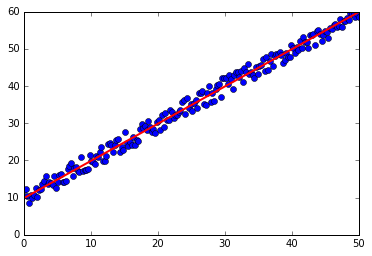

In [110]:
y_GG = lin_reg(GG.params(),x)
plt.figure()
plt.plot(x,exp_data,'o',x,y_GG,'r',lw=2)
plt.show()

Plot the path followed from initial guess to final solution:
1. Using Stochastic GDA
2. Using both StoGDA and SysGDA
3. Using SysGDA and two different runs of the StoGDA

Initial guess is the green point
Target value is the red point

Path of the StoGDA is different any time we run the algorithm
Path to fitting is longer for StoGDA but it is also faster

(1.0, 10.0)


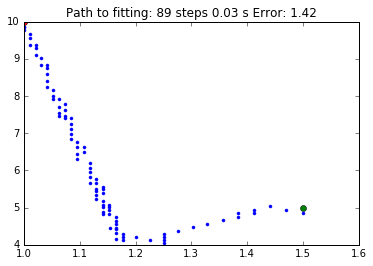

(1.0, 10.0)


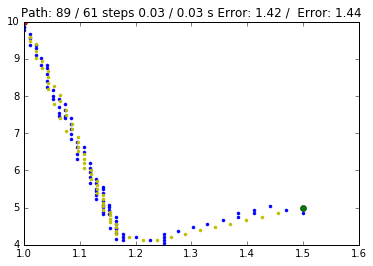

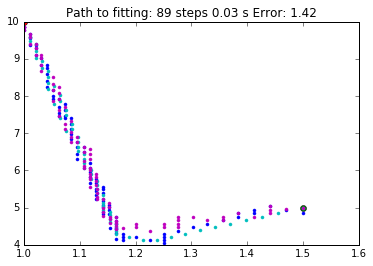

In [111]:
GG.plot_path((0,1),'b',True,pa,pb)
plt.show()
GG.plot_path2(GG2,(0,1),True,pa,pb)
plt.show()
GG.plot_pathN((GG2,GG3),(0,1),True,pa,pb)
plt.show()

The StoGDA is run 200 times and the results are stored in a tuple
Then, the SysGDA is run and the results added to the previous tuple
Then the solution is also calculated by using stats.linregress python function

Obtained results (function parameters)for these 201 executions of GDA are all plotted together with the actual parameters value (target value -red-) and the stats.linregress solution:
1. All cases
2. Only those whose fitting error is smaller than minimum error + 5%
3. Only those whose fitting error is smaller than minimum error + 1%

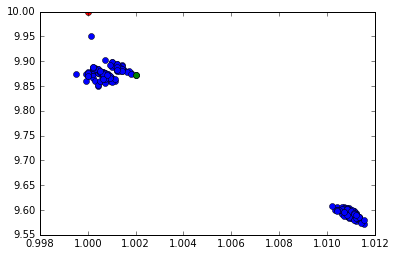

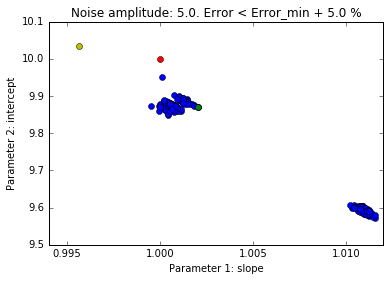

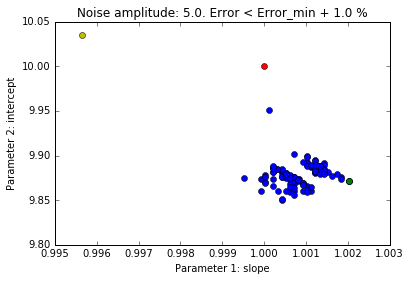

In [112]:
GG_cloud = []
for n in range(200):
    GG = Walk_downGradientML(exp_data, guess_0, (0,1), x, RR, NoStepsOK, lin_reg,F_Error2)
    GG_cloud.append(GG)


NoStepsOK = 3**len(guess_0)
GG = Walk_downGradientML(exp_data, guess_0, (0,1), x, RR, NoStepsOK, lin_reg,F_Error2)
GG_cloud.append(GG)
GG.plot_cloud(tuple(GG_cloud),(0,1),True,pa,pb)
plt.show()

error_lim = 1.05
GG.plot_Bestcloud(tuple(GG_cloud),error_lim,(0,1),'n.a.',True,pa,pb)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,exp_data)
plt.plot(slope,intercept,'oy')
plt.xlabel('Parameter 1: slope')
plt.ylabel('Parameter 2: intercept')
plt.title('Noise amplitude: ' + str(NoiseAmp) + '. Error < Error_min + ' + str((error_lim - 1.0) * 100.)[0:3] + ' %')
plt.show()

error_lim = 1.01
GG.plot_Bestcloud(tuple(GG_cloud),error_lim,(0,1),'n.a.',True,pa,pb)
plt.plot(slope,intercept,'oy')
plt.xlabel('Parameter 1: slope')
plt.ylabel('Parameter 2: intercept')
plt.title('Noise amplitude: ' + str(NoiseAmp) + '. Error < Error_min + ' + str((error_lim - 1.0) * 100.)[0:3] + ' %')
plt.show()


# Example 2
## Polynomial fitting (second order)

Generate some data for a second order polynom, add some noise and calculate the best fit using the numpy.polyfit algorimth

In [113]:
plt.close('all')
REC_LEN = 100
x = np.linspace(0,10,REC_LEN)
pa, pb, pc = 1.0, 3.0, 10.0
yy = polym_2([pa, pb, pc],x)
noise = []
NoiseAmp = 2.5
for n in range(len(x)):
    noise.append((random.random()-0.5) * NoiseAmp)
noise = np.array(noise)
exp_data = yy + noise
pf = np.polyfit(x,exp_data,2)

Set an initial guess
Runs the StoGDA
Runs the SysGDA
runs the StoGDA (again)
Generate the calculated funtion outpu using the extracted paremeters (StoGDA) and plots the results along with the data

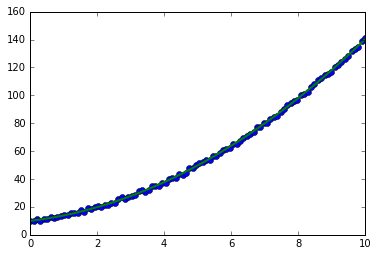

In [114]:
guess_0 = [1.7, 2.7, 7.0]
NoStepsOK = 1
RR = 0.005
GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, polym_2, F_Error2)
NoStepsOK = 3**len(guess_0)
GG2 = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, polym_2, F_Error2)
NoStepsOK = 1
GG3 = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, polym_2, F_Error2)


y_GG = polym_2(GG.params(),x)
plt.figure()
plt.plot(x,exp_data,'o',x,y_GG,lw=2)
plt.show()

Plot the path to fitting for:
1. StoGDA
2. StoGDA + SysGDA

using the plot_path function.

Path to fitting is longer but faster for StoGDA

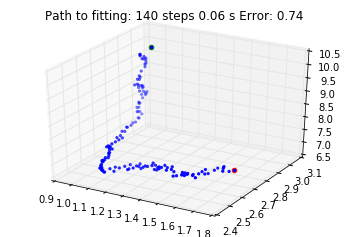

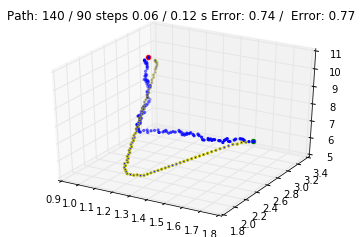

In [115]:
GG.plot_path((0,1,2),'b',True,pa,pb,pc)
GG.plot_path2(GG2,(0,1,2),True,pa,pb,pc)

Runs StoGDA 100 times
Runs SysGDA once

Plot all extracted parameters
Red: target value
Yellow: extracted value by numpy.polyfit
Green: SysGDA
Blue: StoGDA

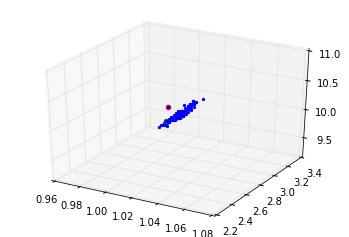

C:\Users\Anaconda\Anaconda3\lib\site-packages\ipykernel\__main__.py:238: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


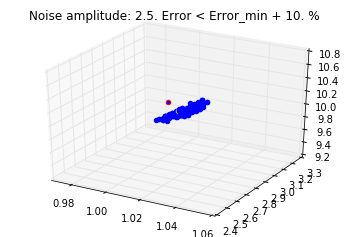

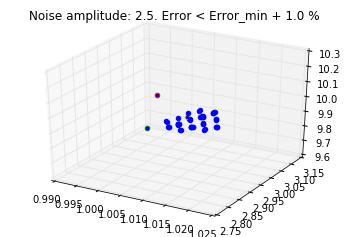

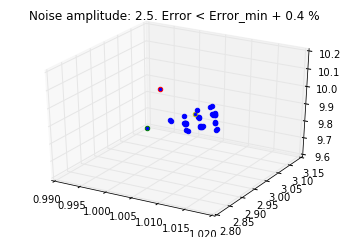

In [116]:
GG_cloud = []
for n in range(100):
    GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, polym_2, F_Error2)
    GG_cloud.append(GG)
    
NoStepsOK = 3**len(guess_0)
GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, polym_2, F_Error2)
GG_cloud.append(GG)
GG.plot_cloud(tuple(GG_cloud),(0,1,2),True,pa,pb,pc)
plt.show()

error_lim = 1.1
GG.plot_Bestcloud(tuple(GG_cloud),error_lim,(0,1,2),pf,True,pa,pb,pc)
plt.title('Noise amplitude: ' + str(NoiseAmp) + '. Error < Error_min + ' + str((error_lim - 1.0) * 100.)[0:3] + ' %')
plt.show()

error_lim = 1.01
GG.plot_Bestcloud(tuple(GG_cloud),error_lim,(0,1,2),pf,True,pa,pb,pc)
plt.title('Noise amplitude: ' + str(NoiseAmp) + '. Error < Error_min + ' + str((error_lim - 1.0) * 100.)[0:3] + ' %')
plt.show()

error_lim = 1.005
GG.plot_Bestcloud(tuple(GG_cloud),error_lim,(0,1,2),pf,True,pa,pb,pc)
plt.title('Noise amplitude: ' + str(NoiseAmp) + '. Error < Error_min + ' + str((error_lim - 1.0) * 100.)[0:3] + ' %')
plt.show()

# Example 3
## Damped oscillator

Firt generate some data and add some noise

In [117]:
REC_LEN = 500
params = [2.,0.5,0.1]
pa, pb, pc = params[0], params[1], params[2]
x = np.linspace(0,60,REC_LEN)
yy = damped_osc(params,x)
NoiseAmp = 0.05
noise = []
for n in range(len(x)):
    noise.append((random.random()-0.5)* NoiseAmp)
noise = np.array(noise)
exp_data = yy + noise * np.complex(1,1)

Select StoGDA (NoStepsOK =1)
Set initial guess
Set step size

Perform:
1. StoGDA
2. (change NoStepsOK) SysGDA

Plot path to fit for both StoGDA and StoGDA
As in previous cases StoGDA path is longer but the algorithm is faster

Plot calculated function output with extracted parameters and data.

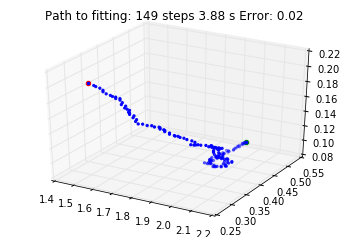

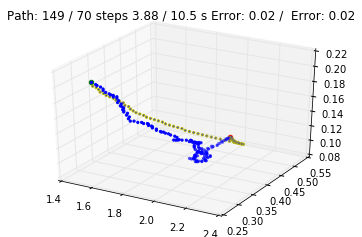

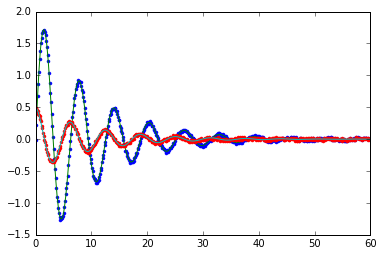

In [118]:
NoStepsOK = 1
guess_0 = (1.5, 0.3, 0.2)
RR = 0.005
GG1 = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, damped_osc, F_Error2)
GG1.plot_path((0,1,2),'b',True,pa,pb,pc)
plt.show()

NoStepsOK = 3**len(guess_0)
GG2 = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, damped_osc, F_Error2)
GG1.plot_path2(GG2,(0,1,2),True,pa,pb,pc)
plt.show()

yy2 = damped_osc(GG2.params(),x)
plt.figure()
plt.plot(x,np.real(exp_data.T),'.',x,np.real(yy2),x,np.imag(exp_data.T),'.',x,np.imag(yy2))
plt.show()

Select StoGDA
run StoGDA 10 times
Run SysGDA once

plot all obtained parameters values (plot_cloud)

plot only thos cases where error < error_min + 10%

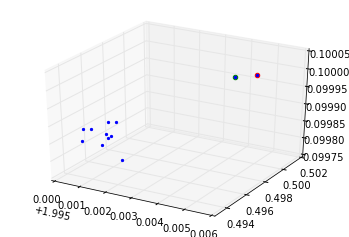

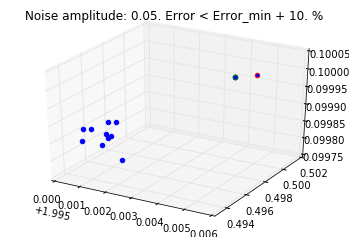

In [119]:
NoStepsOK = 1
GG_cloud = []
for n in range(10):
    GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, damped_osc, F_Error2)
    GG_cloud.append(GG)
    
NoStepsOK = 3**len(guess_0)
GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, damped_osc, F_Error2)
GG_cloud.append(GG)
GG.plot_cloud(tuple(GG_cloud),(0,1,2),True,pa,pb,pc)
plt.show()

error_lim = 1.1
GG.plot_Bestcloud(tuple(GG_cloud),error_lim,(0,1,2),'n.a.',True,pa,pb,pc)
plt.title('Noise amplitude: ' + str(NoiseAmp) + '. Error < Error_min + ' + str((error_lim - 1.0) * 100.)[0:3] + ' %')
plt.show()


# Example 4
## Linear chirp

Generate data and add some noise


In [120]:
REC_LEN = 400
x = np.linspace(0,1e-6,REC_LEN)
poc = 2 * 3.141592 * 4e6 /2e-6
params = [0.1, 1e6, poc*1.1]
pa, pb, pc = params[0], params[1], params[2]
guess_0 = (0.5, 0.8e6, pc*1.1)
yyd = lin_chirp(params,x)

NoiseAmp = 0.2
noise = []
for n in range(len(x)):
    noise.append((random.random()-0.5)* NoiseAmp)
noise = np.array(noise)

exp_data = yyd + noise

Set GDA parameters: Step size (RR = 0.005),
Run StoGDA  
Run SysGDA

Plot path to fitting for both cases

Plot calculated function using extracted parameters and plot data set

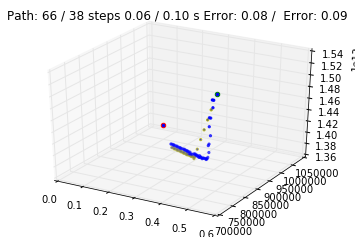

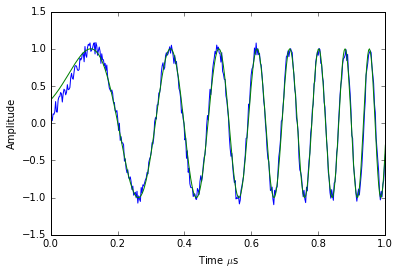

In [121]:
NoStepsOK = 1
RR = 0.005
GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, lin_chirp, F_Error2)
NoStepsOK = 3**len(guess_0)
GG2 = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, lin_chirp, F_Error2)

GG.plot_path2(GG2,(0,1,2),True,pa,pb,pc)
plt.show()

yyd2 = lin_chirp(GG.params(),x)
plt.figure()
plt.plot(x*1e6,exp_data,x*1e6,yyd2)
plt.xlabel(r'Time $\mu$s')
plt.ylabel('Amplitude')
plt.show()

Run StoGDA 100 times

Run SysGDA once

Plot all obtained parameters

Blue: StoGDA
Green: SysGDA
Red: target

Plot those cases whose error < error_min + 10%

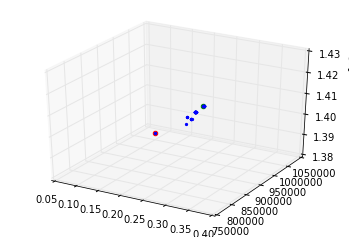

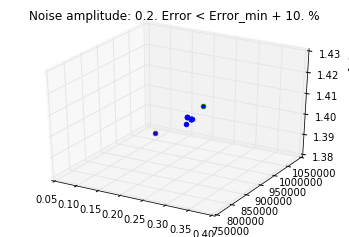

In [122]:
NoStepsOK = 1
GG_cloud = []
for n in range(50):
    GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, lin_chirp, F_Error2)
    GG_cloud.append(GG)
    
NoStepsOK = 3**len(guess_0)
GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, lin_chirp, F_Error2)
GG_cloud.append(GG)
GG.plot_cloud(tuple(GG_cloud),(0,1,2),True,pa,pb,pc)
plt.show()
error_lim =1.1
GG.plot_Bestcloud(tuple(GG_cloud),error_lim,(0,1,2),'n.a.',True,pa,pb,pc)
plt.title('Noise amplitude: ' + str(NoiseAmp) + '. Error < Error_min + ' + str((error_lim - 1.0) * 100.)[0:3] + ' %')
plt.show()

# Example 5
## Gained linear chirp

Generate data and add some noise


In [123]:
NoStepsOK = 1
REC_LEN = 400
x = np.linspace(0,1e-6,REC_LEN)
poc = 2 * 3.141592 * 4e6 /2e-6
params = [0.1, 1e6, poc*1.1]
pa, pb, pc = params[0], params[1], params[2]
guess_0 = (0.5, 0.8e6, pc*1.1)

yyd = gained_chirp(params,x)

NoiseAmp = 0.3
noise = []
for n in range(len(x)):
    noise.append((random.random()-0.5)* NoiseAmp)
noise = np.array(noise)
exp_data = yyd + noise

Solve IP once both StoGDA and SysGDA

plot path

Solve the StoGDA 50 times

plots results

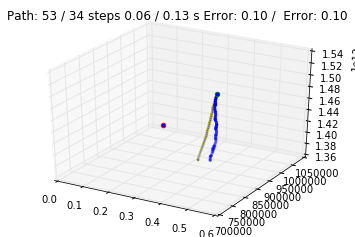

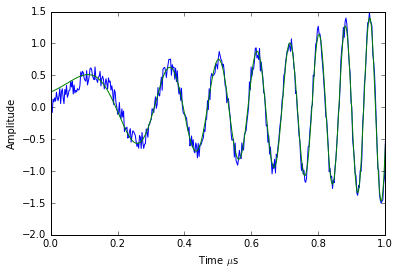

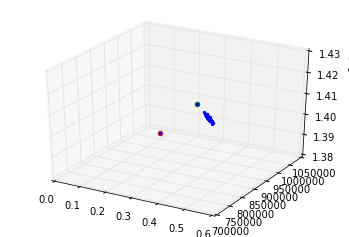

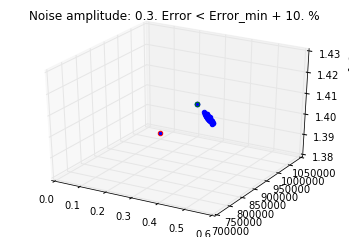

In [124]:
RR = 0.001
GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, gained_chirp, F_Error2)

NoStepsOK = 3**len(guess_0)
GG2 = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, gained_chirp, F_Error2)
GG.plot_path2(GG2,(0,1,2),True,pa,pb,pc)
plt.show()

yyd2 = gained_chirp(GG.params(),x)
plt.figure()
plt.plot(x*1e6,exp_data,x*1e6,yyd2)
plt.xlabel(r'Time $\mu$s')
plt.ylabel('Amplitude')
plt.show()

NoStepsOK = 1
GG_cloud = []
for n in range(50):
    GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, gained_chirp, F_Error2)
    GG_cloud.append(GG)
    
NoStepsOK = (len(guess_0))**3
GG = Walk_downGradientML(exp_data, guess_0, (0,1,2), x, RR, NoStepsOK, gained_chirp, F_Error2)
GG_cloud.append(GG)
GG.plot_cloud(tuple(GG_cloud),(0,1,2),True,pa,pb,pc)
plt.show()

error_lim =1.1
GG.plot_Bestcloud(tuple(GG_cloud),error_lim,(0,1,2),'n.a.',True,pa,pb,pc)
plt.title('Noise amplitude: ' + str(NoiseAmp) + '. Error < Error_min + ' + str((error_lim - 1.0) * 100.)[0:3] + ' %')
plt.show()

# Example 6
## Transmission coeff. narrow band

Generate data and add some noise

In [125]:
x = np.linspace(100e3,.4e6,400)
params = [400., 2e-3, 1e3, 40.0, 1.0]
TT = T_coef(params,x)
NoiseAmp = 0.3e-4
noise = []
for n in range(len(x)):
    noise.append((random.random()-0.5)*NoiseAmp)
noise = np.array(noise)
exp_data = TT + noise * np.complex(1,1) / (np.abs(TT) / np.max(np.abs(TT)))

Run GDA and present results in a similar way as in the previous cases

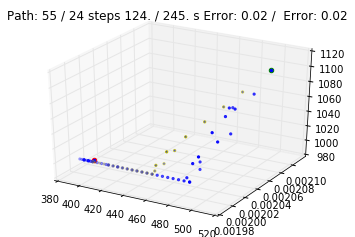

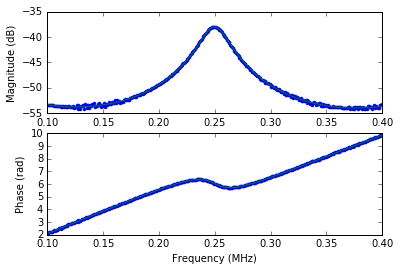

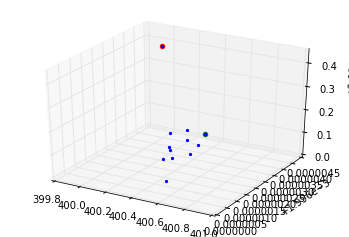

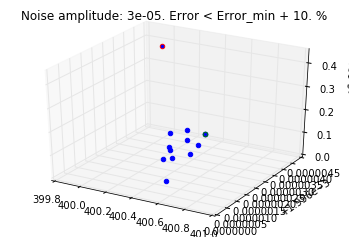

In [126]:
NoStepsOK = 1
guess_0 = (500, 2.1e-3, 1.1e3, 45.0, 0.9)
RR = 0.005 
GG = Walk_downGradientML(exp_data, guess_0, (0,1,2,3), x, RR, NoStepsOK, T_coef, F_Error)

NoStepsOK = 3**len(guess_0)
GG2 = Walk_downGradientML(exp_data, guess_0, (0,1,2,3), x, RR, NoStepsOK, T_coef, F_Error)
GG.plot_path2(GG2,(0,1,2),True,params[0], params[1], params[2])
plt.show()

plt.figure()
fitted = T_coef(GG.params(),x)
plt.subplot(211)
plt.plot(x/1e6,20*np.log10(np.abs(exp_data)),'.',x/1e6,20*np.log10(np.abs(fitted)))
plt.ylabel('Magnitude (dB)')
plt.subplot(212)
plt.plot(x/1e6,np.unwrap(np.angle((exp_data))),'.',x/1e6,np.unwrap(np.angle((fitted))))
plt.ylabel('Phase (rad)')
plt.xlabel('Frequency (MHz)')
plt.show()

NoStepsOK = 1
GG_cloud = []
for n in range(10):
    GG = Walk_downGradientML(exp_data, guess_0, (0,1,2,3), x, RR, NoStepsOK, T_coef, F_Error)
    GG_cloud.append(GG)
    
NoStepsOK = 3**len(guess_0)
GG = Walk_downGradientML(exp_data, guess_0, (0,1,2,3), x, RR, NoStepsOK, T_coef, F_Error)
GG_cloud.append(GG)
GG.plot_cloud(tuple(GG_cloud),(0,1,2),True,params[0], params[1], params[2])

error_lim =1.1
GG.plot_Bestcloud(tuple(GG_cloud),error_lim,(0,1,2),'n.a.',True,params[0], params[1], params[2])
plt.title('Noise amplitude: ' + str(NoiseAmp) + '. Error < Error_min + ' + str((error_lim - 1.0) * 100.)[0:3] + ' %')
plt.show()

# Example 7
## Trans. coeff. wide band

Using same parameters as in the previous case, now generate a data set over a wider frequency range

In [128]:
x = np.linspace(100e3,2e6,250)
guess_0 = tuple(GG.params())
TT = T_coef(params,x)
NoiseAmp = 0.3e-4
noise = []
for n in range(len(x)):
    noise.append((random.random()-0.5)*NoiseAmp)
noise = np.array(noise)
exp_data = TT + noise * np.complex(1,1) / (np.abs(TT) / np.max(np.abs(TT)))

Run GDA

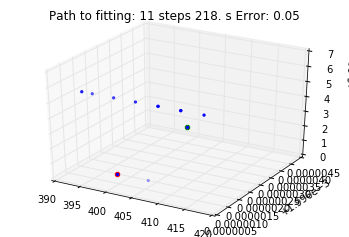

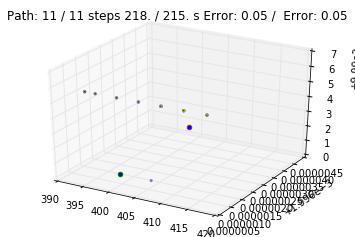

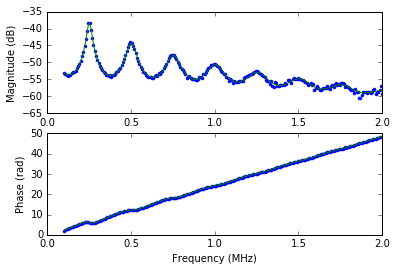

In [129]:
RR = 0.005 
GG = Walk_downGradientML(exp_data, guess_0, (0,1,2,3,4), x, RR, NoStepsOK, T_coef, F_Error)

GG.plot_path((0,1,2),'b',True,params[0], params[1], params[2])

NoStepsOK = 3**len(guess_0)
GG2 = Walk_downGradientML(exp_data, guess_0, (0,1,2,3,4), x, RR, NoStepsOK, T_coef, F_Error)

GG.plot_path2(GG2,(0,1,2),True,params[0], params[1], params[2])

plt.figure()
fitted = T_coef(GG.params(),x)
plt.subplot(211)
plt.plot(x/1e6,20*np.log10(np.abs(exp_data)),'.',x/1e6,20*np.log10(np.abs(fitted)))
plt.ylabel('Magnitude (dB)')
plt.subplot(212)
plt.plot(x/1e6,np.unwrap(np.angle((exp_data))),'.',x/1e6,np.unwrap(np.angle((fitted))))
plt.ylabel('Phase (rad)')
plt.xlabel('Frequency (MHz)')
plt.show()